In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
import scipy
import pickle
import scipy.interpolate as interp
from matplotlib.colors import SymLogNorm, LogNorm
from lmfit import Minimizer, Parameters
from os.path import join

from ctisim import ITL_AMP_GEOM, FloatingOutputAmplifier, SegmentSimulator, BaseOutputAmplifier
from ctisim import LinearTrap, SplineTrap
from ctisim.matrix import electronics_operator, trap_operator
from ctisim.utils import OverscanParameterResults
from ctisim.fitting import SimpleModel, SimulatedModel

amp_geom = ITL_AMP_GEOM
ncols = amp_geom.nx + amp_geom.prescan_width
read_noise = 7.0

main_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/'

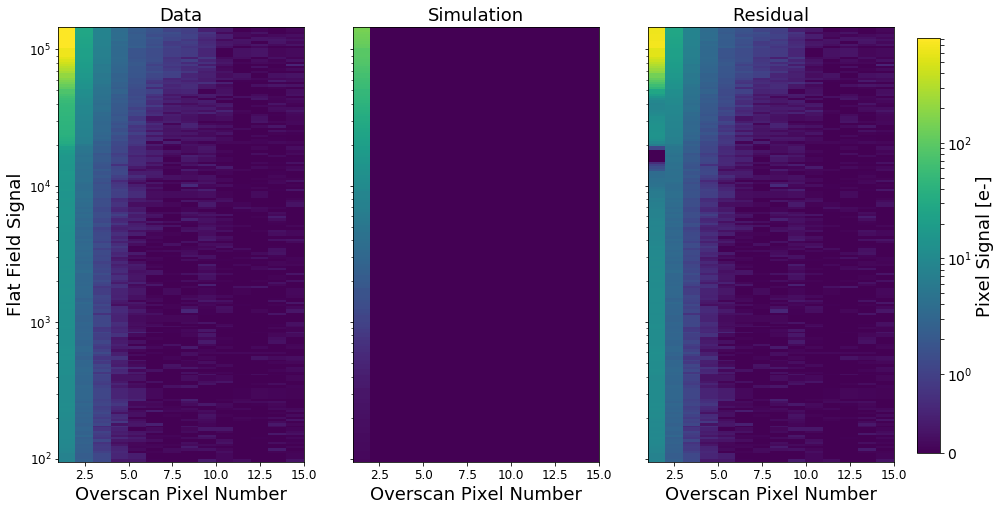

In [19]:
raft_name = 'R02'
ccd_name = 'S02'
sensor_id = '{0}_{1}'.format(raft_name, ccd_name)

param_results = OverscanParameterResults.from_fits(join(main_dir, raft_name, ccd_name, 
                                                        '{0}_parameter_results.fits'.format(sensor_id)))
infile = join(main_dir, raft_name, ccd_name, '{0}_overscan_results.fits'.format(sensor_id))
hdulist = fits.open(infile)
max_signal = 150000.
error = 7.2/np.sqrt(2000.)

start = 1
stop = 15
num_transfers = 512

amp = 9

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
params = Parameters()
params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=True)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)

## Setting up PColor plot
vmin = 0.0
vmax = np.max(data)
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, data, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, model, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im2 = axes[2].pcolor(X, Y, data-model,
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_title('Data', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Simulation', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[2].set_title('Residual', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Pixel Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

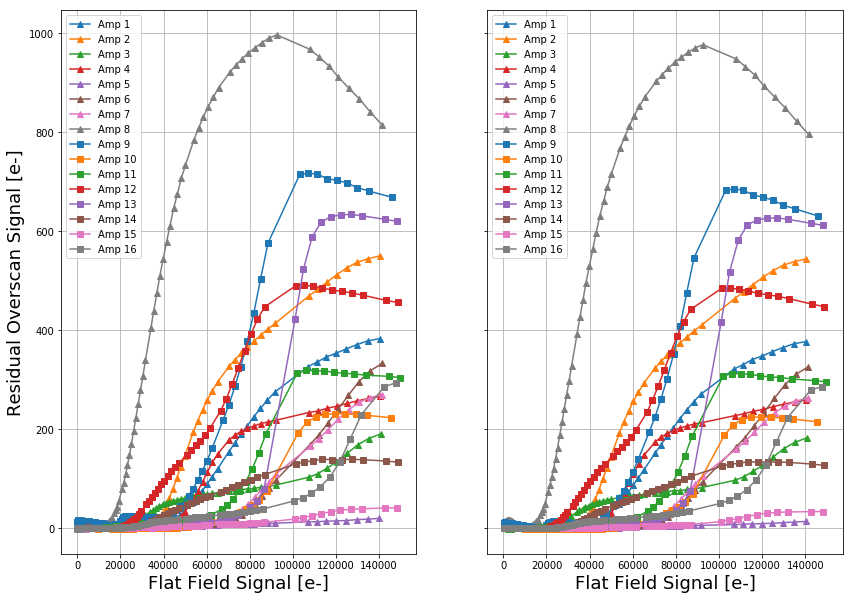

In [20]:
spltraps = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
cmap = plt.get_cmap("tab10")
for amp in range(1, 17):
    
    if amp > 8: marker='s'
    else: marker = '^'
    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    ## Model
    params = Parameters()
    params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=True)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
    model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)
    
    res = np.sum((data-model)[:, :3], axis=1)
    
    axes[0].plot(signals, res, label='Amp {0}'.format(amp), marker=marker, color = cmap((amp-1)%8))
    axes[1].plot(signals, (data-model)[:,0], label='Amp {0}'.format(amp), marker=marker, color = cmap((amp-1)%8))

    
    x = signals
    y = res
    # Pad left with ramp
    y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
    x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

    # Pad right with constant
    y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
    x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

    f = interp.interp1d(x, y)
    spltraps[amp] = SplineTrap(f, 0.4, 1)
    pickle.dump(spltraps[amp], open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'wb'))

axes[0].legend()
axes[0].set_ylabel('Residual Overscan Signal [e-]', fontsize=18)
axes[0].set_xlabel('Flat Field Signal [e-]', fontsize=18)
axes[0].grid(which='both', axis='both')
axes[1].legend()
axes[1].set_xlabel('Flat Field Signal [e-]', fontsize=18)
axes[1].grid(which='both', axis='both')

## Investigating Overcorrection

In [21]:
raft_name = 'R02'
ccd_name = 'S02'
sensor_id = '{0}_{1}'.format(raft_name, ccd_name)

## Make ramp image from data
infile = join(main_dir, raft_name, ccd_name, '{0}_overscan_results.fits'.format(sensor_id))
hdulist = fits.open(infile)
max_signal = 150000.
amp = 9
ncols = ITL_AMP_GEOM.nx+ITL_AMP_GEOM.prescan_width

all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
imarr[:, ncols:] = data

In [22]:
## See what electronics correction does
param_results = OverscanParameterResults.from_fits(join(main_dir, raft_name, ccd_name, 
                                                        '{0}_parameter_results.fits'.format(sensor_id)))
E = electronics_operator(imarr, param_results.drift_scales[amp],
                         param_results.decay_times[amp],
                         param_results.thresholds[amp],
                         num_previous_pixels=15)

corrected_electronics = imarr-E

## See what trap correction does
cti = param_results.cti_results[amp]
trap = pickle.load(open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'rb'))
T = trap_operator(imarr, trap)
corrected = corrected_electronics-(1-cti)*T
print(cti)

2.0932428e-06


/nfs/slac/g/ki/ki19/lsst/snyder18/software/pymodules/ctisim/matrix.py:52: RuntimeWarning: divide by zero encountered in true_divide
  r = np.exp(-1/tau)


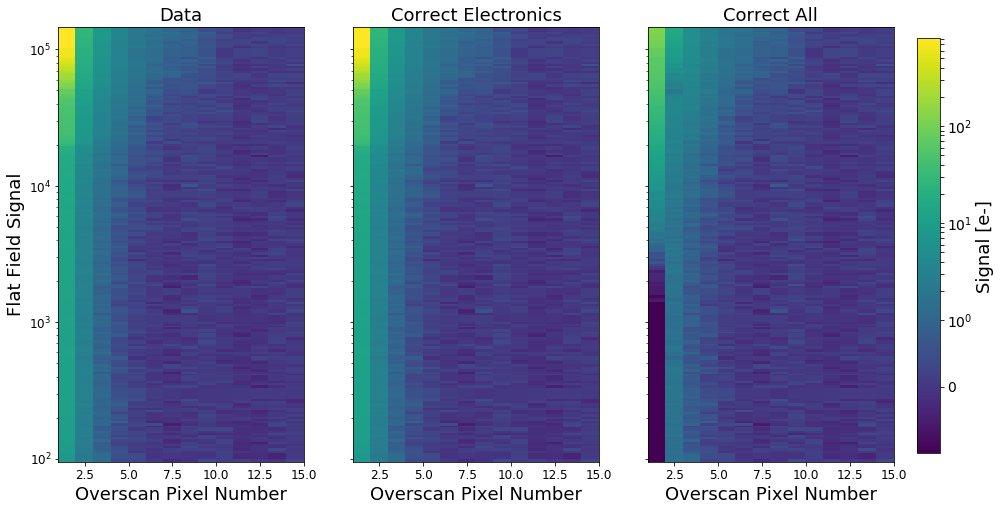

In [23]:
start = 1
stop = 15

## Setting up PColor plot
vmin = -1.0
vmax = np.max(imarr[:, ncols+start:ncols+stop])
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, imarr[:, ncols+start:ncols+stop], 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, corrected_electronics[:, ncols+start:ncols+stop], 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im2 = axes[2].pcolor(X, Y, corrected[:, ncols+start:ncols+stop], 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)

axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_title('Data', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Correct Electronics', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[2].set_title('Correct All', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

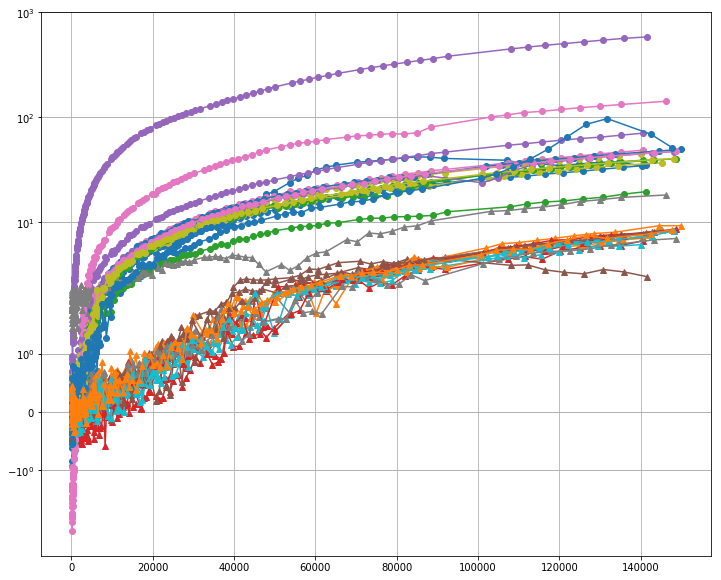

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

for amp in range(1, 17):
    
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

    imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
    ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
    imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
    imarr[:, ncols:] = data
    
    ## See what electronics correction does
    param_results = OverscanParameterResults.from_fits(join(main_dir, raft_name, ccd_name, 
                                                            '{0}_parameter_results.fits'.format(sensor_id)))
    E = electronics_operator(imarr, param_results.drift_scales[amp],
                             param_results.decay_times[amp],
                             param_results.thresholds[amp],
                             num_previous_pixels=15)

    corrected_electronics = imarr-E

    ## See what trap correction does
    cti = param_results.cti_results[amp]
    trap = pickle.load(open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'rb'))
    T = trap_operator(imarr, trap, tau=0.4)
    corrected = corrected_electronics-(1-cti)*T

    ax.plot(signals, corrected[:, 513], marker='o')
    ax.plot(signals, corrected[:, 514], marker='^')
    
ax.grid(which='both')
ax.set_yscale('symlog')